In [1]:
# We start by importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Defining Runge-function

In [2]:
np.random.seed(73)
rng = np.random.default_rng(73)

def runge_function(x, noise=True):
    y = 1 / (1 + 25 * x**2)
    if noise:
        y += np.random.normal(0, 0.1, size=x.shape)
    return y


In [3]:

def polynomial_features(x, degree, intercept=True):
    n = len(x)
    if intercept:
        X = np.zeros((n, degree+1))
        X[:, 0] = 1
        for i in range(1, degree+1):
            X[:, i] = x**i
    else:
        X = np.zeros((n, degree))
        for i in range(degree):
            X[:, i] = x**(i+1)
    return X

In [4]:
def ols_fit(X, y):
    return np.linalg.pinv(X) @ y



In [5]:
datapoints = [10, 50, 100, 200, 500, 1000]
poly_degrees = list(range(1, 16))
results_ols = {}

for n in datapoints:
    x = np.linspace(-1, 1, n)
    y = runge_function(x, 0.5)

    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)

    for p in poly_degrees:
        Xp = polynomial_features(x, p, intercept=False)
        X_train, X_test = Xp[idx_train, :], Xp[idx_test, :]
        y_train, y_test = y[idx_train], y[idx_test]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        y_offset = y_train.mean()
        y_train_s, y_test_s = y_train - y_offset, y_test - y_offset

        theta = ols_fit(X_train_s, y_train_s)

        y_hat_train, y_hat_test = X_train_s @ theta, X_test_s @ theta

        mse_train = np.mean((y_train_s - y_hat_train)**2)
        mse_test = np.mean((y_test_s - y_hat_test)**2)

        R2_train = 1 - np.sum((y_train_s - y_hat_train)**2) / np.sum((y_train_s - y_train_s.mean())**2)
        R2_test = 1 - np.sum((y_test_s - y_hat_test)**2) / np.sum((y_test_s - y_train_s.mean())**2)

        results_ols[(n, p)] = {
            "theta": theta,
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train, "R2_test": R2_test,
        }


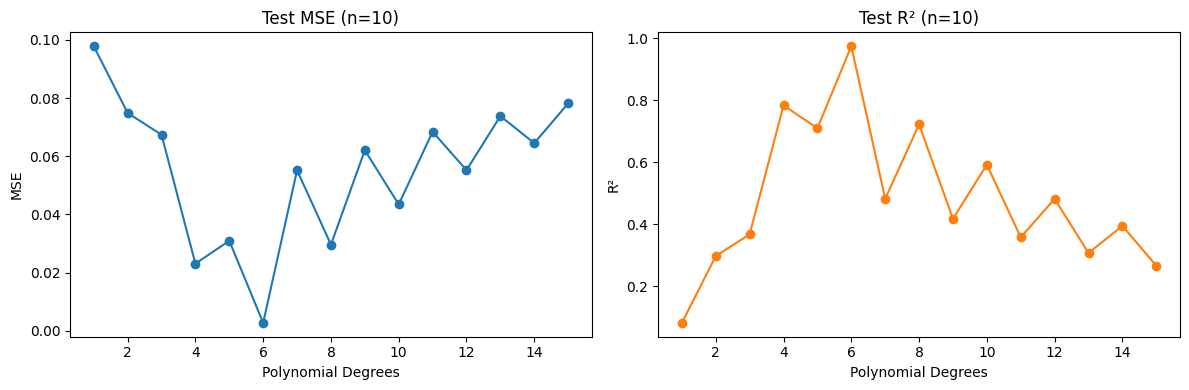

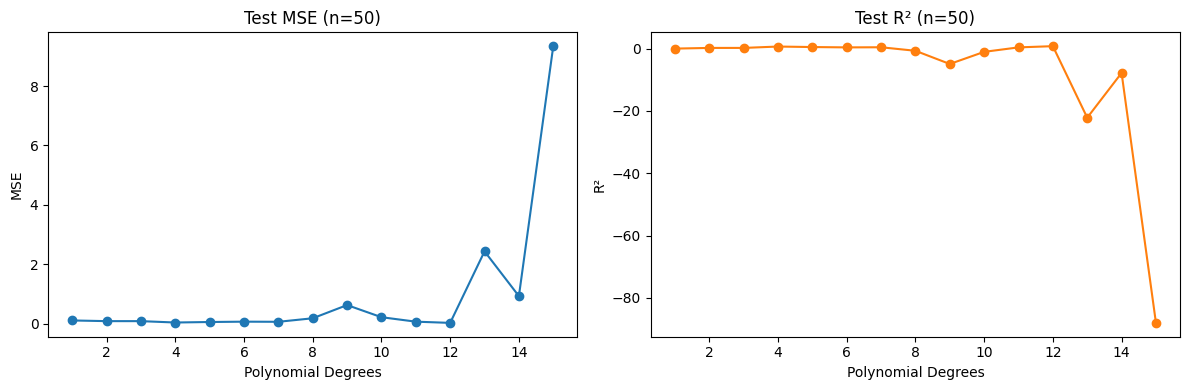

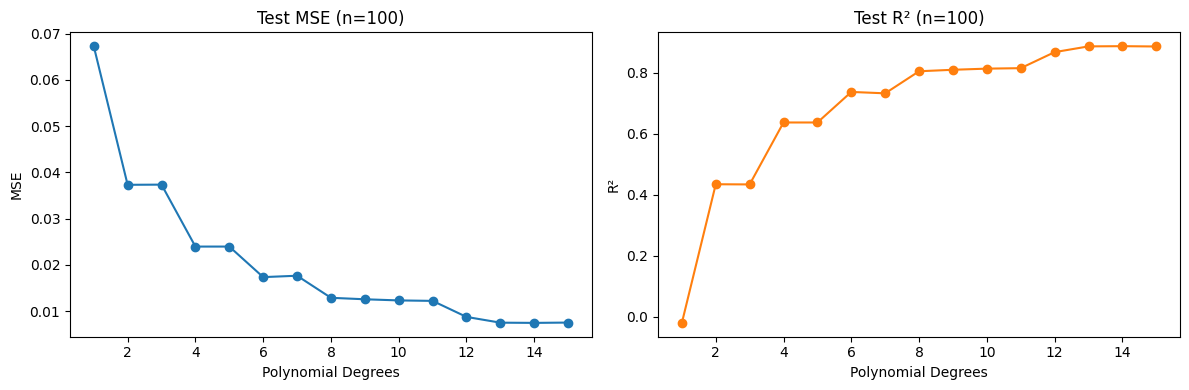

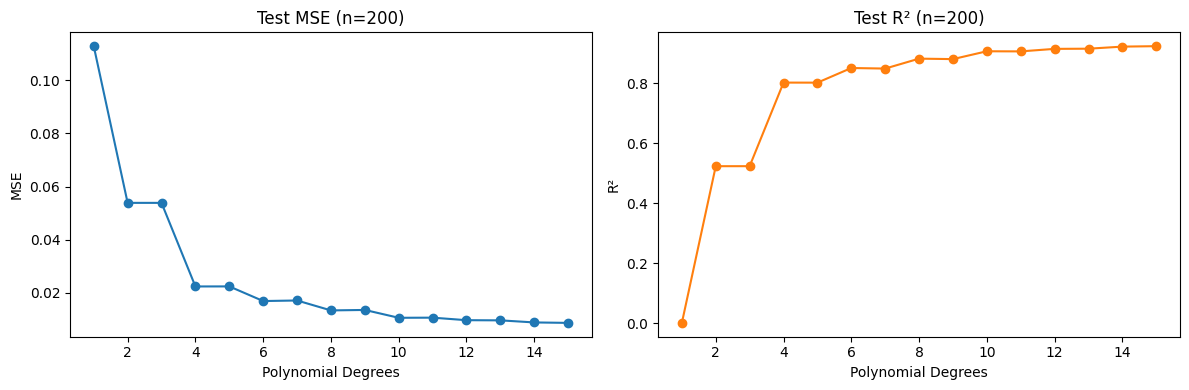

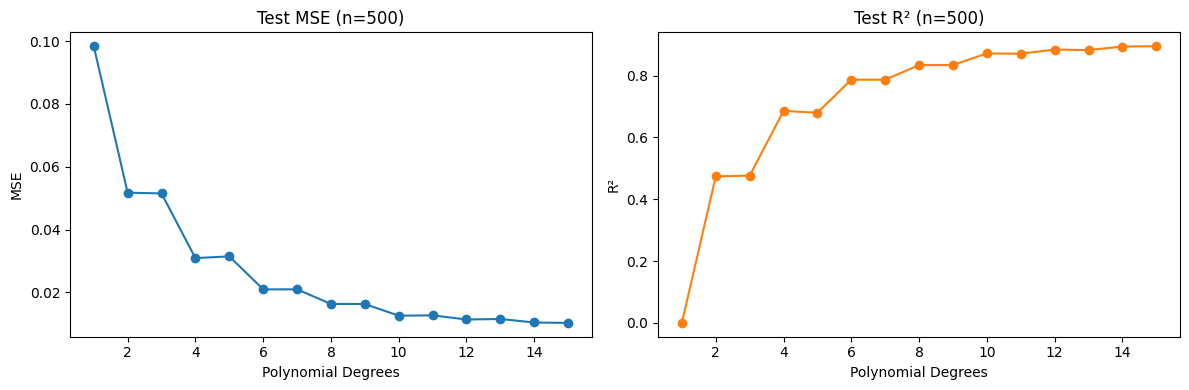

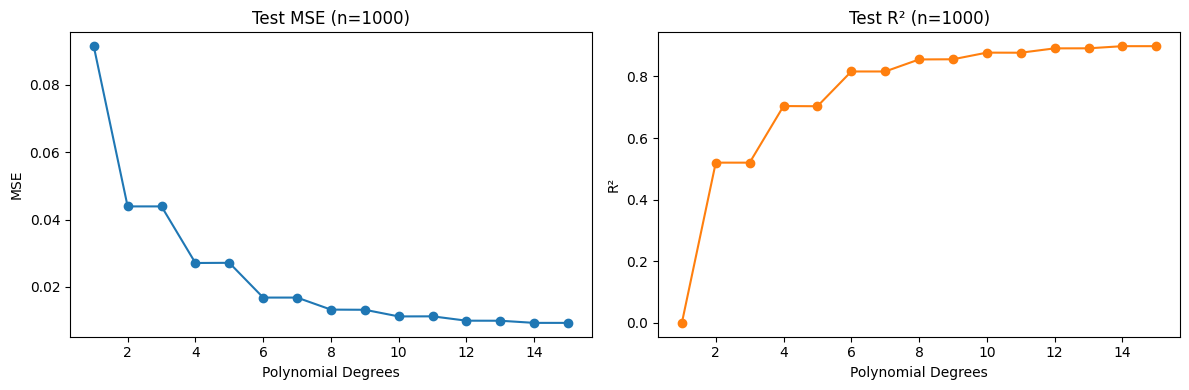

In [6]:
def plot_mse_r2(results, n_values):
    for n_focus in n_values:
        ps = sorted({p for (n_key, p) in results.keys() if n_key == n_focus})
        mse_values = [results[(n_focus, p)]["mse_test"] for p in ps]
        r2_values = [results[(n_focus, p)]["R2_test"] for p in ps]

        fig, axes = plt.subplots(1, 2, figsize=(12,4))

        # MSE plot
        axes[0].plot(ps, mse_values, marker="o", color="tab:blue")
        axes[0].set_title(f"Test MSE (n={n_focus})")
        axes[0].set_xlabel("Polynomial Degrees")
        axes[0].set_ylabel("MSE")

        # R² plot
        axes[1].plot(ps, r2_values, marker="o", color="tab:orange")
        axes[1].set_title(f"Test R² (n={n_focus})")
        axes[1].set_xlabel("Polynomial Degrees")
        axes[1].set_ylabel("R²")

        plt.tight_layout()
        plt.show()

plot_mse_r2(results_ols, datapoints)



In [7]:
def plot_train_mse_r2(results):
    ns = sorted({n for (n, _) in results.keys()})
    ps = sorted({p for (_, p) in results.keys()})

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for n_focus in ns:
        values = [results[(n_focus, p)]["mse_train"] for p in ps]
        axes[0].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[0].set_title("Train MSE - OLS")
    axes[0].set_xlabel("Polynomial Degrees")
    axes[0].set_ylabel("MSE")
    axes[0].legend(title="Datapoints")

    for n_focus in ns:
        values = [results[(n_focus, p)]["R2_train"] for p in ps]
        axes[1].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[1].set_title("Train R² - OLS")
    axes[1].set_xlabel("Polynomial Degrees")
    axes[1].set_ylabel("R²")
    axes[1].legend(title="Datapoints")

    plt.tight_layout()
    plt.show()


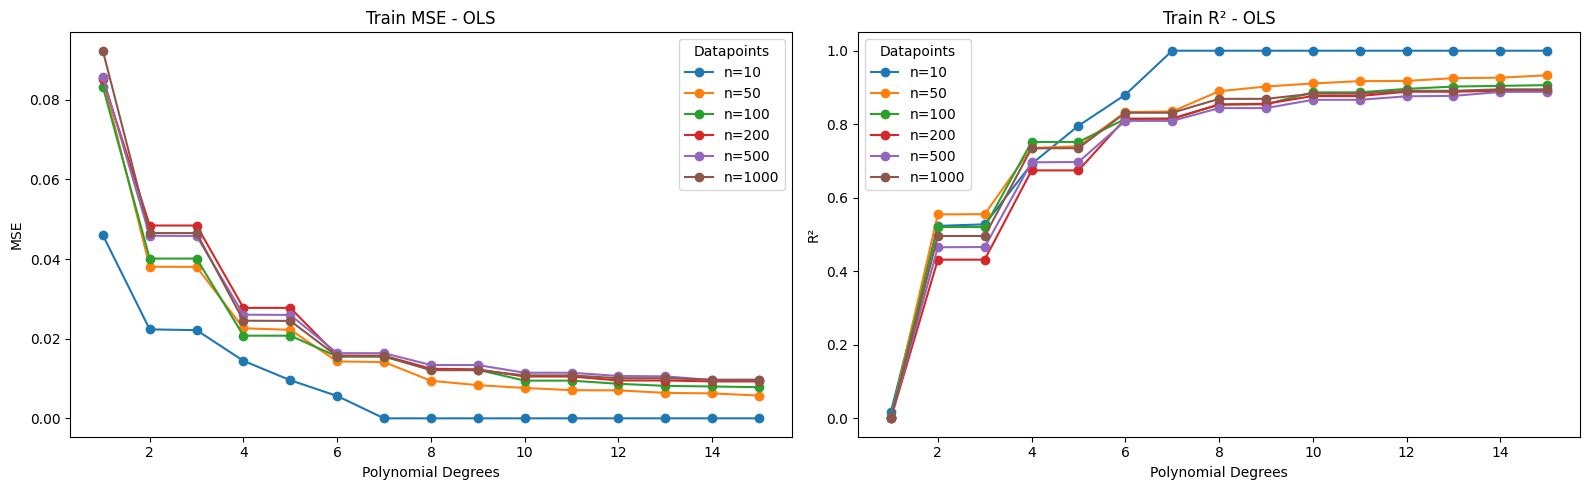

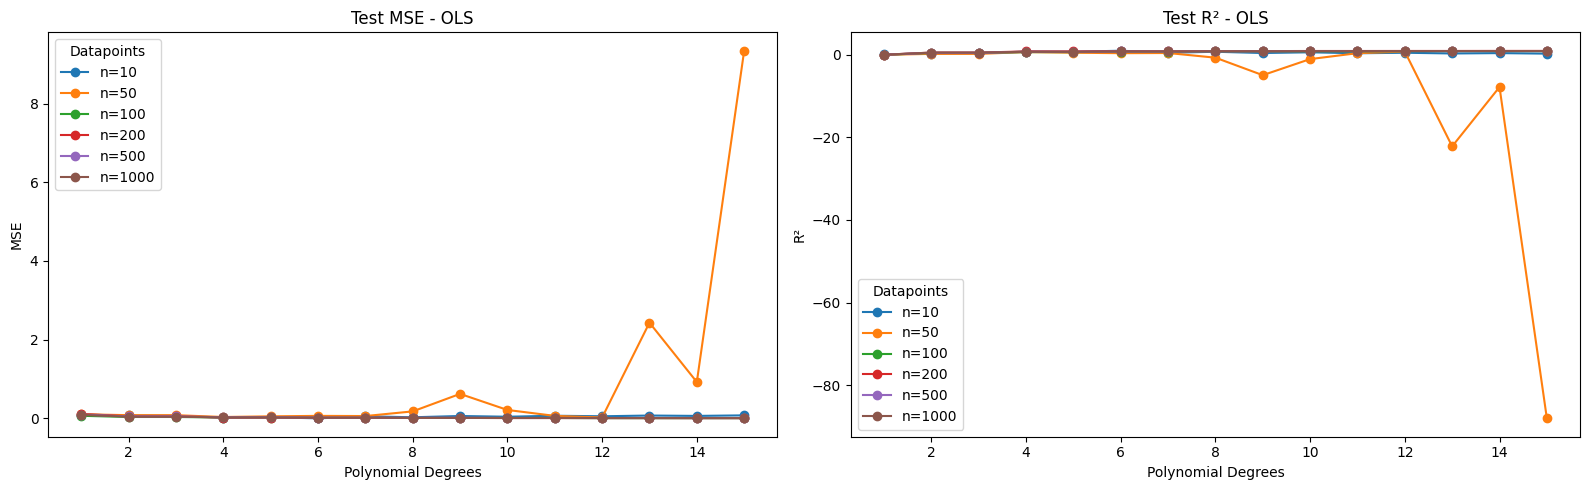

In [8]:
def plot_test_mse_r2(results):
    ns = sorted({n for (n, _) in results.keys()})
    ps = sorted({p for (_, p) in results.keys()})

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for n_focus in ns:
        values = [results[(n_focus, p)]["mse_test"] for p in ps]
        axes[0].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[0].set_title("Test MSE - OLS")
    axes[0].set_xlabel("Polynomial Degrees")
    axes[0].set_ylabel("MSE")
    axes[0].legend(title="Datapoints")

    for n_focus in ns:
        values = [results[(n_focus, p)]["R2_test"] for p in ps]
        axes[1].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[1].set_title("Test R² - OLS")
    axes[1].set_xlabel("Polynomial Degrees")
    axes[1].set_ylabel("R²")
    axes[1].legend(title="Datapoints")

    plt.tight_layout()
    plt.show()

plot_train_mse_r2(results_ols)
plot_test_mse_r2(results_ols)



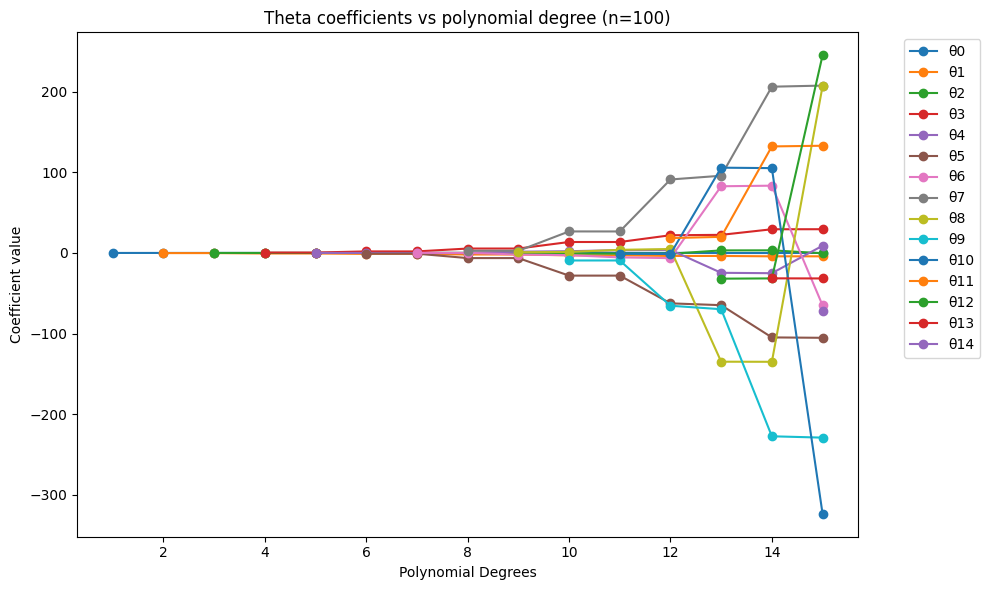

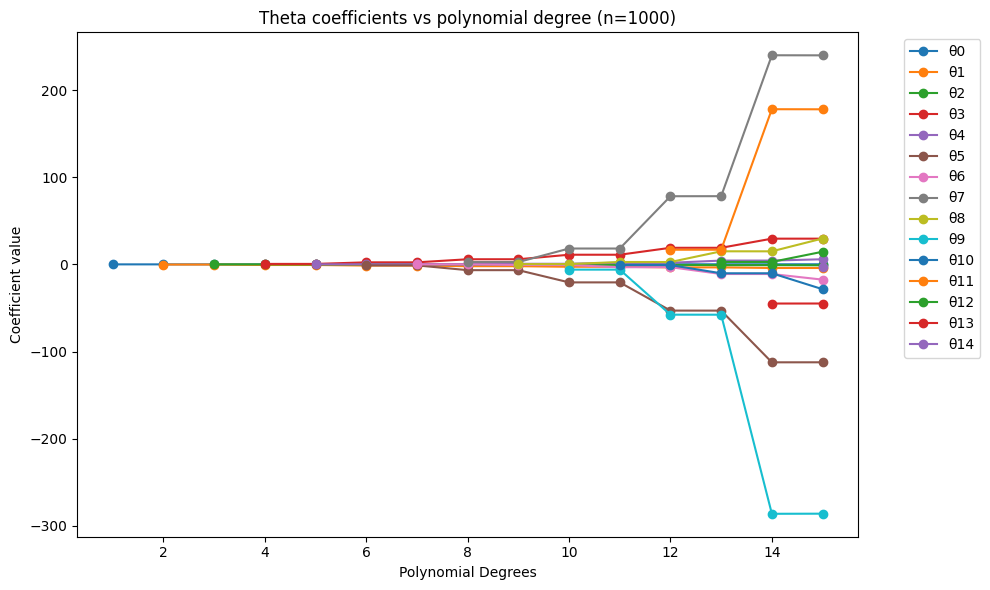

In [9]:
def plot_theta(results, n_focus):
    ps = sorted({p for (n_key, p) in results.keys() if n_key == n_focus})
    thetas = [results[(n_focus, p)]["theta"] for p in ps if (n_focus, p) in results]

    if not thetas:
        print(f"No results found for n={n_focus}")
        return

    plt.figure(figsize=(10,6))

    max_len = max(len(theta) for theta in thetas)
    for j in range(max_len):
        coeffs = [theta[j] if j < len(theta) else np.nan for theta in thetas]
        plt.plot(ps, coeffs, marker="o", label=f"θ{j}")

    plt.title(f"Theta coefficients vs polynomial degree (n={n_focus})")
    plt.xlabel("Polynomial Degrees")
    plt.ylabel("Coefficient value")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


# Plot theta
plot_theta(results_ols, n_focus=100)
plot_theta(results_ols, n_focus=1000)


In [10]:
def summarize_results(results, n_values, degrees, metric):
    data = []
    for n in n_values:
        for p in degrees:
            if (n, p) in results:
                data.append({
                    "n": n,
                    "degree": p,
                    metric: results[(n, p)][metric]
                })
    return pd.DataFrame(data)

# summary
df_mse_test = summarize_results(results_ols, datapoints, poly_degrees, "mse_test")
df_r2_test  = summarize_results(results_ols, datapoints, poly_degrees, "R2_test")

display(df_mse_test.head(10))
display(df_r2_test.head(10))


,n,degree,mse_test
0,10,1,0.097842
1,10,2,0.074882
2,10,3,0.067382
3,10,4,0.023043
4,10,5,0.030908
5,10,6,0.002678
6,10,7,0.055170
7,10,8,0.029592
8,10,9,0.062043
9,10,10,0.043429


,n,degree,R2_test
0,10,1,0.082425
1,10,2,0.297748
2,10,3,0.368086
3,10,4,0.783901
4,10,5,0.710142
5,10,6,0.974888
6,10,7,0.482613
7,10,8,0.722481
8,10,9,0.418151
9,10,10,0.592719


In [11]:
# Finn beste degree (lowest test MSE) for every n
best_models = df_mse_test.loc[df_mse_test.groupby("n")["mse_test"].idxmin()]
print("Best polynomial degree per dataset size (based on lowest test MSE):")
display(best_models)


Best polynomial degree per dataset size (based on lowest test MSE):


,n,degree,mse_test
5,10,6,0.002678
26,50,12,0.024119
43,100,14,0.007463
59,200,15,0.008703
74,500,15,0.010332
89,1000,15,0.009306


### Task b - Ridge Regression

In [12]:
def ridge_fit(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    return np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y

lambdas = [1e-6, 1e-4, 1e-2, 0.1, 1, 10]
results_ridge = {}

for n in datapoints:
    x = np.linspace(-1, 1, n)
    y = runge_function(x, 0.5)

    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)

    for p in poly_degrees:
        Xp = polynomial_features(x, p, intercept=False)
        X_train, X_test = Xp[idx_train, :], Xp[idx_test, :]
        y_train, y_test = y[idx_train], y[idx_test]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        y_offset = y_train.mean()
        y_train_s, y_test_s = y_train - y_offset, y_test - y_offset

        for lam in lambdas:
            theta = ridge_fit(X_train_s, y_train_s, lam)
            y_hat_train, y_hat_test = X_train_s @ theta, X_test_s @ theta

            mse_train = np.mean((y_train_s - y_hat_train)**2)
            mse_test = np.mean((y_test_s - y_hat_test)**2)

            R2_train = 1 - np.sum((y_train_s - y_hat_train)**2) / np.sum((y_train_s - y_train_s.mean())**2)
            R2_test = 1 - np.sum((y_test_s - y_hat_test)**2) / np.sum((y_test_s - y_train_s.mean())**2)

            results_ridge[(n, p, lam)] = {
                "theta": theta,
                "mse_train": mse_train, "mse_test": mse_test,
                "R2_train": R2_train, "R2_test": R2_test
            }

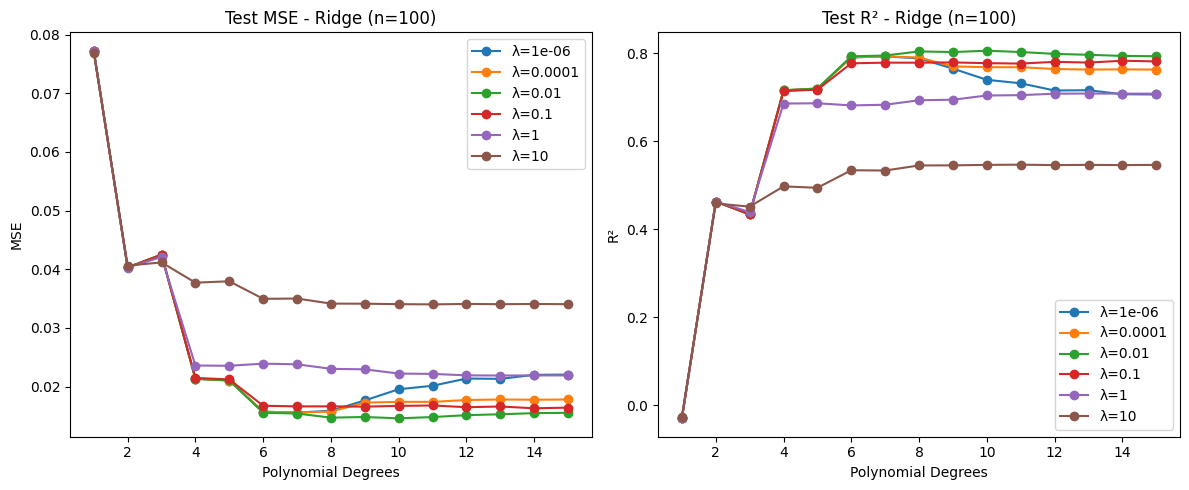

In [13]:
def plot_ridge_mse_r2(results, n_focus, lam_values):
    ps = sorted({p for (n, p, lam) in results.keys() if n == n_focus})

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # MSE
    for lam in lam_values:
        values = [results[(n_focus, p, lam)]["mse_test"] for p in ps]
        axes[0].plot(ps, values, marker="o", label=f"λ={lam}")
    axes[0].set_title(f"Test MSE - Ridge (n={n_focus})")
    axes[0].set_xlabel("Polynomial Degrees")
    axes[0].set_ylabel("MSE")
    axes[0].legend()

    # R²
    for lam in lam_values:
        values = [results[(n_focus, p, lam)]["R2_test"] for p in ps]
        axes[1].plot(ps, values, marker="o", label=f"λ={lam}")
    axes[1].set_title(f"Test R² - Ridge (n={n_focus})")
    axes[1].set_xlabel("Polynomial Degrees")
    axes[1].set_ylabel("R²")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_ridge_mse_r2(results_ridge, n_focus=100, lam_values=lambdas)


In [14]:
def summarize_ridge(results, datapoints, degrees, lambdas):
    data = []
    for n in datapoints:
        for p in degrees:
            for lam in lambdas:
                if (n, p, lam) in results:
                    entry = results[(n, p, lam)]
                    data.append({
                        "n": n,
                        "degree": p,
                        "lambda": lam,
                        "MSE_test": entry["mse_test"],
                        "R2_test": entry["R2_test"]
                    })
    return pd.DataFrame(data)

df_ridge = summarize_ridge(results_ridge, datapoints, poly_degrees, lambdas)
best_ridge = df_ridge.loc[df_ridge.groupby("n")["MSE_test"].idxmin()]

display(best_ridge)


,n,degree,lambda,MSE_test,R2_test
26,10,5,0.010000,0.000019,0.999779
138,50,9,0.000001,0.028003,0.829759
236,100,10,0.010000,0.014596,0.805448
324,200,10,0.000001,0.012236,0.838496
444,500,15,0.000001,0.008834,0.914165
528,1000,14,0.000001,0.010564,0.888178
